In [1]:
# 입력한 데이터를 토큰화 및 시퀀스 변화 -> padding(고정길이화) -> 임베딩(단어 -> 벡터화)
# 1D Convolution + poling 반복! 반복하는 이유는? 특징을 잡아야하기 때문에.
# 반복을 한 다음 Flatten 을 사용하여 Dense(은닉층)을 거쳐 출력(Soft Max , 이진분류)을 하게 됨
# 그것을 토대로 학습(Adam + binary_crossentropy)을 하고 손실함수를 이용하여 검증하고 테스트하고 평가를 한 후 시각화를 한다.

# 원-핫을 하면 단어 간의 관계를 전혀 알 수 없다.
# 학습되는 것 처럼 보이겠지만 학습이 되지 않기 때문에 방향성이 있는 벡터화를 해야한다.
# cosine 등을 이용하여 단어간의 유사성을 확인할 수 있음.
# 차원이 아무리 많아도 1~3차원을 만들어 규칙을 보고 예측함.

# tensorflow를 사용할 시 python 3.11 버전으로 하는게 안전함.

### tensorflow를 사용할 시 python 3.11 버전으로 하는게 안전함.

#### 터미널에서 가상환경 만드는 방법

conda env list 입력.

conda create -n p311 python=3.11 가상환경 만듬. (p311 이 부분은 가상환경 이름.)

y/n -> y 입력

#### conda의 기본채널에 없는 것들이 있기때문에 그럴때는 pip로 install 하거나 채널을 찾아야함.
-------------------------------------------
conda env list conda 가상환경들 다 나옴

conda activate final  final의 가상환경을 선택.

conda list conda에 있는 list들이 다 나옴

conda install tensorflow tensorflow 설치.

conda deactivate

conda remove -n final --all final 디렉토리를 삭제한다는 것.

- 말뭉치 로딩 (nltk) 데이터 로딩
- 토큰화 (잘라야지) 빈고 기반 인덱싱 / 잘게 쪼갠다음 텍스트를 숫자로 변환
- 시퀀스 패딩 고정 길이 배치 구성
- 임베딩 단어를 밀집형태의 벡터로 표현 및 학습
- 임베딩 발전
    - 한계 : 작은 데이터에서는 일반화 부족
    - 발전 : 사전학습(Word2vec) , 문맥 임베딩(BERT , GPT)

In [14]:
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# sample data 만들기
texts = [
    ' I really love this movie ',
    ' I hate this boring film ',
    ' My love suhan ',
    ' My whole world in these frames ',
    ' My bae '
]

# 토큰화 객체 (최대 단어 10 , oov 토큰 지정)
tokenizer = Tokenizer(num_words=20, oov_token='UNK') # OOV란 “사전에 없는 단어”를 뜻해서 시퀀스에는 사전에 없는 단어를 1로 표시
tokenizer.fit_on_texts(texts)
print(f'단어 인덱스를 만드는 애 : {tokenizer.word_index}')

# 시퀀스를 맞춰줘야함 ( 문장을 숫자로 바꾸는 것 )
seqs = tokenizer.texts_to_sequences(texts)
print(f'원본 시퀀스 : {seqs}')

# 길이를 맞춰줘야하기때문에 padding을 사용.
# 패딩 (최대 길이 8개)
padded = pad_sequences(seqs , maxlen=8 , padding='post')
print(f'패딩 결과는? {padded}  사이즈는? {padded.shape}')

단어 인덱스를 만드는 애 : {'UNK': 1, 'my': 2, 'i': 3, 'love': 4, 'this': 5, 'really': 6, 'movie': 7, 'hate': 8, 'boring': 9, 'film': 10, 'suhan': 11, 'whole': 12, 'world': 13, 'in': 14, 'these': 15, 'frames': 16, 'bae': 17}
원본 시퀀스 : [[3, 6, 4, 5, 7], [3, 8, 5, 9, 10], [2, 4, 11], [2, 12, 13, 14, 15, 16], [2, 17]]
패딩 결과는? [[ 3  6  4  5  7  0  0  0]
 [ 3  8  5  9 10  0  0  0]
 [ 2  4 11  0  0  0  0  0]
 [ 2 12 13 14 15 16  0  0]
 [ 2 17  0  0  0  0  0  0]]  사이즈는? (5, 8)


In [ ]:
# 단어 사이의 연관성이 없어.
# 그래서 임베딩을 하는거임.
# 임베딩 레이어를 사용할꺼임

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# 패딩된 시퀀스인 padded를 사용할꺼임
vocab_size = 18 # UNK를 포함한 단어 인덱스 최대값에 + 1
embed_dim = 4 # 작은 차원 수
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size , output_dim=embed_dim , input_length=8)
])
embeddings = model.predict(padded)
print(f'임베딩 tensor 모양 : {embeddings.shape}') #(5 , 8 , 4) 가 나올꺼같음
print(f'첫 문장의 첫 단어 벡터는 ?  {embeddings[0,0,:]}') # I 에 대한 벡터값이 출력됨

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
임베딩 tensor 모양 : (5, 8, 4)
첫 문장의 첫 단어 벡터는 ?  [ 0.04378352 -0.01106647  0.04632774  0.02125299]


In [ ]:
# 1D Convoltion을 봐보자
import numpy as np
import tensorflow as tf

# 임의의 시퀀스를 지정 (배치 1 , 길이 6 , 임베딩 4)
x = np.random.rand(1,6,4).astype('float32')
conv = tf.keras.layers.Conv1D(
    filters = 2,  # 2개의 패턴을 감지할꺼야. 부정? 긍정?처럼 감지하는 단계
    kernel_size = 3,  # 3-gram 3x3 네모로 찍는거임.
    activation = 'relu' # 패턴을 감지하고 활성함수 통과 시킴
)

y = conv(x)
print(f'입력 shape  {x.shape}')
print(f'출력 shape  {y.shape}') # 입력값의 6개를 3x3네모로 옮겨다니니까 4 출력
print(f'출력값  {y.numpy()}')


입력 shape  (1, 6, 4)
출력 shape  (1, 4, 2)
출력값  [[[1.1425129  0.83391035]
  [0.         0.        ]
  [1.0220065  0.09407622]
  [0.38864788 0.31862098]]]


In [19]:
# MaxPooling

pooling = tf.keras.layers.MaxPool1D(pool_size=2) # 절반으로 줄어들게함
pooled = pooling(y)
print(f'before pooling : {y.shape}')
print(f'after pooling : {pooled.shape}')

before pooling : (1, 4, 2)
after pooling : (1, 2, 2)


In [20]:
# 위에 있는 소스를 다 합쳐보자

In [ ]:
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer # 단어사전 만드는 모듈 / 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences # 길이 맞추는 모듈
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


# sample data 만들기
texts = [
    ' I hate this boring film ',
    ' My love suhan ',
    ' I hate sick ',
    ' My whole world in these frames '
    
]

label = np.array([1,0,1,0])

# LLM 가면 많은 tokenizer 가 많아짐. LLM은 순서가 중요하니 순서 기억해

tokenizer = Tokenizer(num_words=30 , oov_token='UNK')
tokenizer.fit_on_texts(texts) # 단어 사전을 생성함.

seqs = tokenizer.texts_to_sequences(texts) # 단어 사전 기반으로 단어들을 숫자로 변경 ( 길이는 다름! )

# 길이를 맞춰야하는데 길이 맞춘 변수가 학습 데이터가 됨.
padded = pad_sequences(seqs , maxlen=6 , padding='post')
# 여기서 padded는 학습할 건덕지가 없음. 숫자로 되어 있는 데이터일 뿐 , 학습할 데이터로 만들어줘야함.
# 벡터화 해서 비슷한 방향을 바라볼 수 있도록 만들어줘야해. 그걸 해주는게 embedding임.

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(51,8,input_length=6),
    tf.keras.layers.Conv1D(16,3,activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])
#sigmoid 는 값을 1로 주게되면 임계치를 설정해줘야함. 예를 들어 0.5로 주면 0.5 이상이면 1 , 이하면 0 이런식으로 
# softmax 는 여러개의 값을 1로 바꿔주는 역할을 하기때문에 값을 2(0과 1)로 주게되면 softmax를 써야함.
# tensorflow는 알아서 값을 넣어 계산해주는데 파이토치는 레이어별로 다 해줘야함. 계산도 다 해야함.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(padded , label , epochs=15)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - acc: 0.5000 - loss: 0.6942
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7500 - loss: 0.6924
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7500 - loss: 0.6908
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7500 - loss: 0.6894
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7500 - loss: 0.6881
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7500 - loss: 0.6870
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 1.0000 - loss: 0.6860
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 1.0000 - loss: 0.6848
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 1.0000 - loss: 0.6836
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 1.0000 - loss: 0.6824
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 1.0000 - loss: 0.6811
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 1.0000 - loss: 0.6799
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 1.0

In [4]:
print(f"최종훈련 정확도 : {history.history['acc'][-1]}")
preds = model.predict(padded)
print(preds.reshape(-1))
print(f'라벨 : {label}')

최종훈련 정확도 : 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.5078564  0.49585193 0.50729036 0.48205286]
라벨 : [1 0 1 0]


In [26]:
# nltk 가져오기
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

# 재현성 seed 고정

import random
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/kangminji/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - acc: 0.5102 - loss: 0.6926 - val_acc: 0.5437 - val_loss: 0.6921
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - acc: 0.4898 - loss: 0.6935 - val_acc: 0.5437 - val_loss: 0.6923
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - acc: 0.4977 - loss: 0.6929 - val_acc: 0.5219 - val_loss: 0.6920
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - acc: 0.5359 - loss: 0.6916 - val_acc: 0.5156 - val_loss: 0.6905
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - acc: 0.5336 - loss: 0.6911 - val_acc: 0.5188 - val_loss: 0.6917
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - acc: 0.5336 - loss: 0.6906 - val_acc: 0.5156 - val_loss: 0.6936
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - acc: 0.5383 - loss: 0.6894 - val_acc: 0.5188 - val_loss: 0.6949


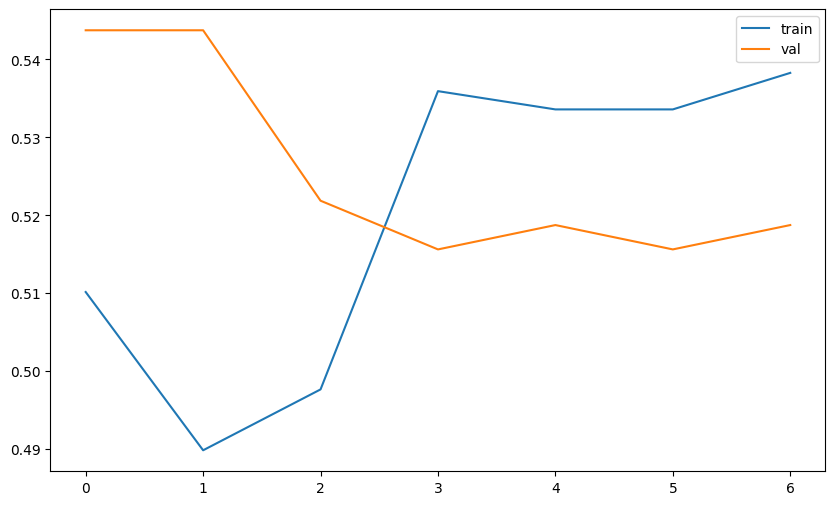

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.5200 - loss: 0.6932
test loss : 0.6931983232498169  test acc : 0.5199999809265137
dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


In [ ]:
# * 별개로 메소드들끼리 . 연결 . 연결 . 연결 이렇게 하는걸 chain기법이라고 함
# 데이터 로딩
ids = movie_reviews.fileids() # 데이터 가져오기
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids]

# 하이퍼 파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩차원
batch_size = 256 # batch_size
epochs = 15 # epoch
# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=10 , oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
# print(f'원본 시퀀스 : {seqs}')
x = pad_sequences(x,maxlen=maxlen,truncating='post') # post 와 pre의 차이는?
# padding 문장 길이가 짧은 애를 채울때 앞에서 채울꺼냐,   / truncating 문장 길이가 긴 애를 앞에서 자를꺼냐 뒤에서 짜를꺼냐 차이.
# padding='pre'/'post': 짧은 문장을 앞/뒤에서 0으로 채움.
# truncating='pre'/'post': 긴 문장을 앞/뒤에서 잘라냄.
# 텍스트 분류는 보통 truncating='post', padding='post'가 실무에서 많이 쓰입니다(문장 앞부분 정보 보존).
#print(f'패딩결과? {padded}  패딩 사이즈? {padded.shape}')
# 라벨 인코딩
label_map = {'pos' : 0 , 'neg' : 1}
y = np.array([label_map.get(c) for c in categories])
# train / test  분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)
# 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1 , output_dim=embed_dim , input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(), # 시퀀스의 구간별 특징 요약 (1열로 펼침)
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),
    # tf.keras.layers.GlobalAveragePooling1D() # 전체 시퀀스의 평균을 구하는 것. ( 시퀀스 차원 없애고 , 채널 축만 남김. ) 채널에 대한 평균
    tf.keras.layers.MaxPool1D(), # 이걸 쓰게 되면
    tf.keras.layers.Flatten(), # 이렇게 펼쳐줘야함..
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2,callbacks=[es]
)
# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')
print(history.history.keys())
# 임의의 데이터로 예측
sample_texts = [
    'To me, you are perfect',
    'Love is a song that never ends',
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

#conv1d   배치크기, 시퀀스길이, 채널수
x = tf.random.normal((32,10,64))
print(tf.keras.layers.Flatten()(x).shape)  
tf.keras.layers.GlobalAvgPool1D()(x).shape  # 각 채널 Feature map 마다 평균

In [ ]:
# Convolution / MaxPooling
# conv1D를 사용하면 배치크기와 시퀀스의 길이 , 채널수가 나와요

# GlobalAvgPool1D() 각 채널 Feature map ??
# Dense층을 거치면서 1차원으로 나오니까.
# 일부 정보가 없어질 수 있음... 대신 과적합은 없지..

In [ ]:
# 학습된 모델을 추론해서 결과 보기

# 개선 아이디어
#     GlobalMaxPooling 사용(Flatten 대신) → 파라미터 감소
#     다중 커널 크기(3,5,7) 병렬 적용 (TextCNN 구조)
#     Pretrained Embeddings (GloVe) 로 초기화
#     과적합 방지: Dropout, L2 Regularization
#     학습률 스케줄링(Cosine annealing, ReduceLROnPlateau)